In [1]:
!pip install node2vec


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import networkx as nx # 图数据挖掘
import numpy as np # 数据分析
import random # 随机数

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
# 《悲惨世界》人物数据集
G = nx.les_miserables_graph()

In [4]:
G.nodes

NodeView(('Napoleon', 'Myriel', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan', 'Valjean', 'Labarre', 'Marguerite', 'MmeDeR', 'Isabeau', 'Gervais', 'Listolier', 'Tholomyes', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'MmeThenardier', 'Thenardier', 'Cosette', 'Javert', 'Fauchelevent', 'Bamatabois', 'Perpetue', 'Simplice', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Pontmercy', 'Boulatruelle', 'Eponine', 'Anzelma', 'Woman2', 'MotherInnocent', 'Gribier', 'MmeBurgon', 'Jondrette', 'Gavroche', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Toussaint', 'Child1', 'Child2', 'Brujon', 'MmeHucheloup'))

In [5]:
len(G)

77

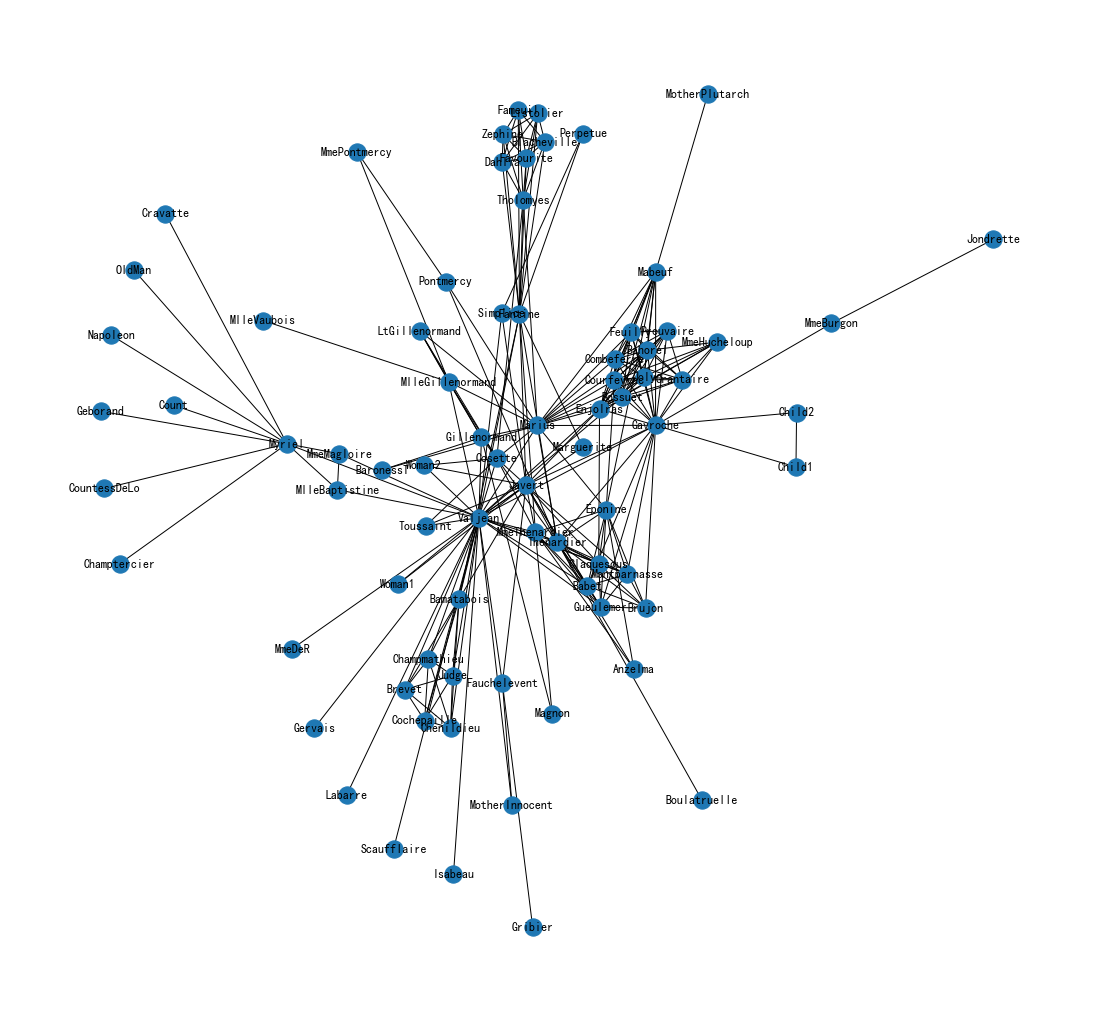

In [6]:
# 可视化
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=5)
nx.draw(G, pos, with_labels=True)
plt.show()

## 构建Node2Vec模型

In [7]:
from node2vec import Node2Vec

In [8]:
# 设置node2vec参数
node2vec = Node2Vec(G, 
                    dimensions=32,  # 嵌入维度
                    p=1,            # 回家参数
                    q=3,          # 外出参数
                    walk_length=10, # 随机游走最大长度
                    num_walks=600,  # 每个节点作为起始节点生成的随机游走个数
                    workers=4       # 并行线程数
                   )

# p=1, q=0.5, n_clusters=6。DFS深度优先搜索，挖掘同质社群
# p=1, q=2, n_clusters=3。BFS宽度优先搜索，挖掘节点的结构功能。

# 训练Node2Vec，参数文档见 gensim.models.Word2Vec
model = node2vec.fit(window=3,    # Skip-Gram窗口大小
                     min_count=1,  # 忽略出现次数低于此阈值的节点（词）
                     batch_words=4 # 每个线程处理的数据量
                    )
X = model.wv.vectors

Computing transition probabilities:   0%|          | 0/77 [00:00<?, ?it/s]

In [9]:
X.shape

(77, 32)

## 节点Embedding聚类可视化

### 运行聚类

In [10]:
# # DBSCAN聚类
# from sklearn.cluster import DBSCAN
# cluster_labels = DBSCAN(eps=0.5, min_samples=6).fit(X).labels_
# print(cluster_labels)

# KMeans聚类
from sklearn.cluster import KMeans
import numpy as np
cluster_labels = KMeans(n_clusters=3).fit(X).labels_
print(cluster_labels)

[0 0 0 0 0 2 2 0 2 1 2 2 0 0 0 0 2 0 0 2 0 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 2 0 0 2 0 2 2 0 2 2 2 0 0 0 0 2 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


### 将networkx中的节点和词向量中的节点对应

将词汇表的节点顺序转为networkx中的节点顺序

In [11]:
colors = []
nodes = list(G.nodes)
for node in nodes: # 按 networkx 的顺序遍历每个节点
    idx = model.wv.key_to_index[str(node)] # 获取这个节点在 embedding 中的索引号
    colors.append(cluster_labels[idx]) # 获取这个节点的聚类结果

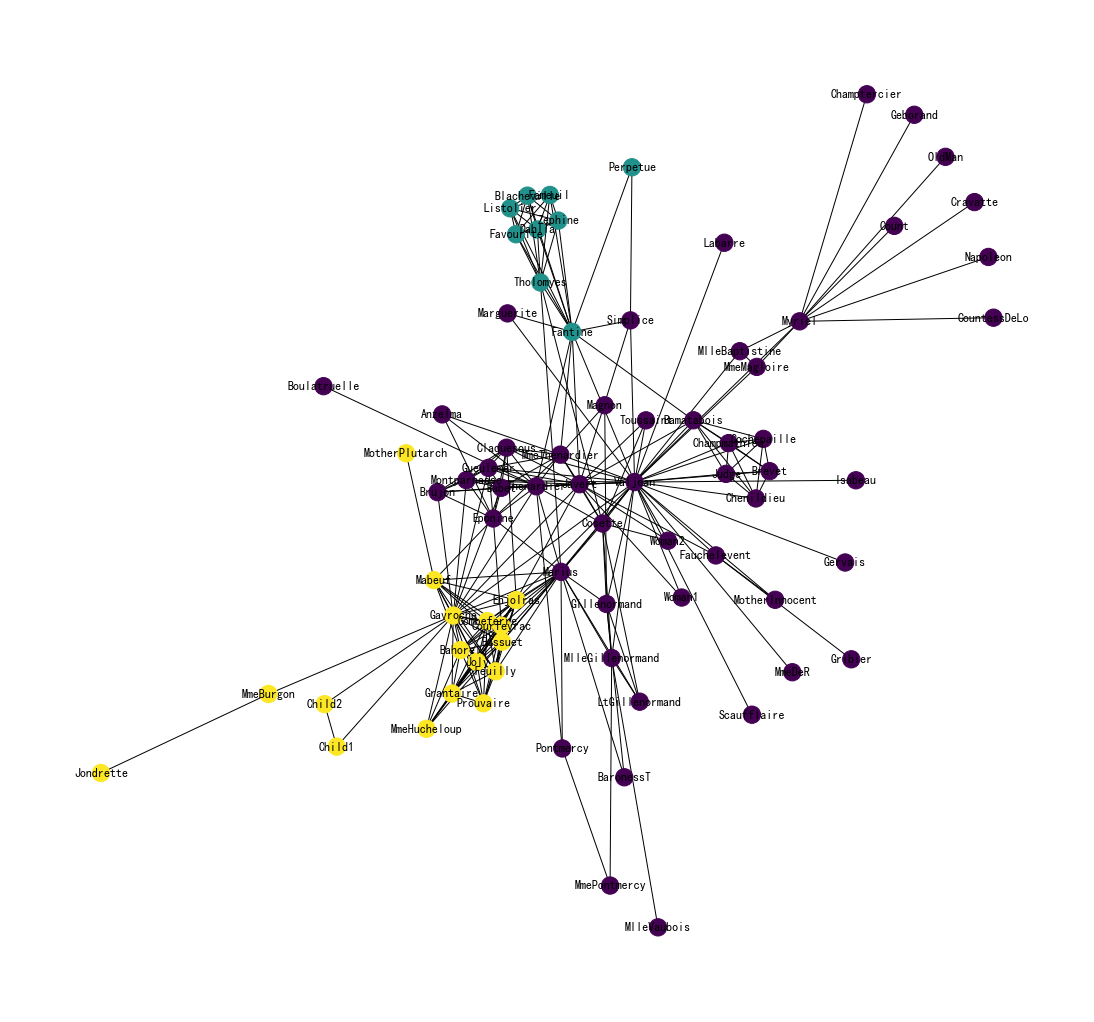

In [12]:
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=10)
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.show()

## 节点Embedding降维可视化

In [13]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

# # 将Embedding用TSNE降维到2维
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, n_iter=5000)
# embed_2d = tsne.fit_transform(X)

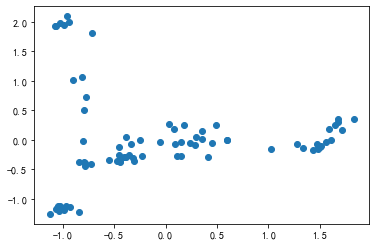

In [14]:
# plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

## 查看Embedding

In [15]:
model.wv.get_vector('Napoleon').shape

(32,)

In [16]:
# 查看某个节点的Embedding
model.wv.get_vector('Napoleon')

array([-0.6622863 , -0.24977265,  0.62761295, -0.22940925, -0.00729814,
       -0.5982749 ,  0.00706103,  0.26893646, -0.20710813, -0.35432464,
        0.49361292, -0.4377681 ,  0.49011812, -0.23957318, -0.10667786,
       -0.28589785, -0.44359612,  0.74978167, -0.12316462,  0.37537622,
        0.24005102,  0.9498929 ,  0.98502636,  0.02622249, -0.18227738,
        0.54668355, -0.09780259,  0.83532804,  0.2184783 ,  0.54571444,
        0.32957682, -0.17910267], dtype=float32)

In [17]:
# 查找 Napoleon 节点的相似节点
model.wv.most_similar('Napoleon')

[('Geborand', 0.9800470471382141),
 ('Cravatte', 0.972311794757843),
 ('OldMan', 0.9669547080993652),
 ('CountessDeLo', 0.9649943113327026),
 ('Champtercier', 0.9355090856552124),
 ('Count', 0.9205031394958496),
 ('MmeMagloire', 0.9164363741874695),
 ('MlleBaptistine', 0.9088934659957886),
 ('Myriel', 0.89610356092453),
 ('Labarre', 0.4870166480541229)]

In [18]:
model.wv.similar_by_word('Napoleon')

[('Geborand', 0.9800470471382141),
 ('Cravatte', 0.972311794757843),
 ('OldMan', 0.9669547080993652),
 ('CountessDeLo', 0.9649943113327026),
 ('Champtercier', 0.9355090856552124),
 ('Count', 0.9205031394958496),
 ('MmeMagloire', 0.9164363741874695),
 ('MlleBaptistine', 0.9088934659957886),
 ('Myriel', 0.89610356092453),
 ('Labarre', 0.4870166480541229)]

In [19]:
# 查看任意两个节点的相似度
model.wv.similarity('Napoleon', 'Champtercier')

0.9355091

In [20]:
# 查看任意两个节点的相似度
model.wv.similarity('Napoleon', 'Brujon')

0.22131719

## 对Edge（连接）做Embedding

In [21]:
from node2vec.edges import HadamardEmbedder

In [22]:
# Hadamard 二元操作符：两个 Embedding 对应元素相乘
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [23]:
# 查看 任意两个节点连接 的 Embedding
edges_embs[('Napoleon', 'Champtercier')]

array([ 2.9028445e-01,  5.3794030e-02,  3.2555628e-01,  9.2431530e-02,
        1.3505357e-04,  3.9249194e-01, -6.5107823e-05,  1.2767616e-01,
        5.5922203e-02, -5.7249120e-03,  2.6230079e-01,  2.7752954e-01,
        2.3439084e-01,  5.4603864e-02, -2.8613883e-03,  6.9509193e-02,
        4.4140100e-02,  4.6015385e-01, -2.1614091e-02,  2.7796906e-01,
        2.6117882e-02,  8.5065752e-01,  9.6837121e-01,  5.5600363e-03,
        6.9738827e-03,  2.8132209e-01,  1.8465608e-02,  6.5539938e-01,
        9.1858238e-02,  3.5252428e-01,  4.7696281e-02,  3.6294162e-02],
      dtype=float32)

In [24]:
# 计算所有 Edge 的 Embedding
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████████████████████████████████████████| 3003/3003.0 [00:00<00:00, 205021.48it/s]


In [25]:
edges_kv.index_to_key

["('Valjean', 'Valjean')",
 "('Marius', 'Valjean')",
 "('Cosette', 'Valjean')",
 "('Thenardier', 'Valjean')",
 "('Myriel', 'Valjean')",
 "('Enjolras', 'Valjean')",
 "('Courfeyrac', 'Valjean')",
 "('Javert', 'Valjean')",
 "('Gavroche', 'Valjean')",
 "('Fantine', 'Valjean')",
 "('Bossuet', 'Valjean')",
 "('Combeferre', 'Valjean')",
 "('MmeMagloire', 'Valjean')",
 "('MmeThenardier', 'Valjean')",
 "('MlleBaptistine', 'Valjean')",
 "('Gillenormand', 'Valjean')",
 "('Joly', 'Valjean')",
 "('Babet', 'Valjean')",
 "('MlleGillenormand', 'Valjean')",
 "('Bahorel', 'Valjean')",
 "('Gueulemer', 'Valjean')",
 "('Feuilly', 'Valjean')",
 "('Favourite', 'Valjean')",
 "('Tholomyes', 'Valjean')",
 "('Blacheville', 'Valjean')",
 "('Dahlia', 'Valjean')",
 "('Fameuil', 'Valjean')",
 "('Listolier', 'Valjean')",
 "('Valjean', 'Zephine')",
 "('Claquesous', 'Valjean')",
 "('Fauchelevent', 'Valjean')",
 "('Judge', 'Valjean')",
 "('Champmathieu', 'Valjean')",
 "('Eponine', 'Valjean')",
 "('Chenildieu', 'Valjean'

In [26]:
# 查看 关系与 某两个节点 最相似的 节点对
edges_kv.most_similar(str(('Bossuet', 'Valjean')))

[("('Prouvaire', 'Valjean')", 0.9466748237609863),
 ("('Combeferre', 'Valjean')", 0.9153020977973938),
 ("('Joly', 'Valjean')", 0.9130967259407043),
 ("('Bahorel', 'Valjean')", 0.9108276963233948),
 ("('Feuilly', 'Valjean')", 0.8760849833488464),
 ("('Enjolras', 'Valjean')", 0.8320848345756531),
 ("('Courfeyrac', 'Valjean')", 0.8281766176223755),
 ("('Grantaire', 'Valjean')", 0.8169528245925903),
 ("('MmeHucheloup', 'Valjean')", 0.7818371653556824),
 ("('Mabeuf', 'Valjean')", 0.7802083492279053)]